In [ ]:
!git clone https://github.com/aditi-govindu/audio-gans.git

Cloning into 'audio-gans'...
fatal: could not read Username for 'https://github.com': No such device or address


In [ ]:
# Import modules
import tensorflow as tf
import tensorflow.keras as K

from tensorflow.keras.applications import VGG16

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense

import numpy as np
import librosa.display, os
import keras.utils as image
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

import tensorflow_hub as hub
import datetime
import matplotlib.pyplot as plt

In [ ]:
pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 KB 23.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283859 sha256=03cf1a50d8b1764429534b40d7ec615d0cccbcb1e5c9d5b1715fae25a14d27b7
  Stored in directory: /root/.cache/pip/wheels/ed/d7/c9/5a0130d06d6310bc6cbe55220e6e72dcb8c4eff9a478717066
Successfully built lime


In [ ]:
# For XAI
import lime
from skimage.segmentation import mark_boundaries

In [ ]:
def generate_prediction_sample(exp, exp_class, weight = 0.1, show_positive = True, hide_background = True):
    '''
    Method to display and highlight super-pixels used by the black-box model to make predictions
    '''

    image, mask = exp.get_image_and_mask(exp_class,
                                         positive_only=show_positive,
                                         num_features=6,
                                         hide_rest=hide_background,
                                         min_weight=weight
                                        )
    %matplotlib inline
    plt.imshow(mark_boundaries(image, mask))
    plt.plot()

# Setting Random Seed

In [ ]:
tf.random.set_seed(42)

# Preprocessing

In [ ]:
# Load data parameters
batch_size = 32
img_height = img_width = 224
channels = 3

root = 'https://github.com/aditi-govindu/audio-gans/tree/main/data' #r'path_to_Spectrogram_folder'

In [ ]:
train_ds = K.utils.image_dataset_from_directory(str(root),
                                               validation_split = 0.2,
                                               subset = 'training',
                                               seed = 42,
                                               image_size = (img_height, img_width),
                                               batch_size = batch_size)

test_ds = K.utils.image_dataset_from_directory(str(root),
                                               validation_split = 0.2,
                                               subset = 'validation',
                                               seed = 42,
                                               image_size = (img_height, img_width),
                                               batch_size = batch_size)

NotFoundError: ignored

In [ ]:
class_names = np.array(train_ds.class_names)
print(class_names)

['fake' 'real']


In [ ]:
# Rescale images
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

In [ ]:
# 32 (224*224*3) sized images in 1 batch
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(16, 224, 224, 3)
(16,)


In [ ]:
batch_size = 32
epochs = 20

In [ ]:
total_train_samples = len(train_ds)
steps_per_epoch = tf.math.ceil(total_train_samples / batch_size)

In [ ]:
total_val_samples = len(test_ds)
validation_steps = tf.math.ceil(total_val_samples / batch_size)

# VGG Model

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

In [ ]:
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
input_shape = (224, 224, 3)

In [ ]:
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

In [ ]:
for layer in vgg16.layers:
    layer.trainable = False

In [ ]:
x = Flatten()(vgg16.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

In [ ]:
model = Model(inputs=vgg16.input, outputs=x)

In [ ]:
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-5), metrics=['accuracy'])

In [ ]:
batch_size = 32
epochs = 20

In [ ]:
len(train_ds)

511

In [ ]:
total_train_samples = len(train_ds)
steps_per_epoch = tf.math.ceil(total_train_samples / batch_size)

In [ ]:
len(test_ds)

128

In [ ]:
total_val_samples = len(test_ds)
validation_steps = tf.math.ceil(total_val_samples / batch_size)

In [ ]:
history = model.fit(train_ds, epochs=epochs, steps_per_epoch=steps_per_epoch,
                    validation_data=test_ds, validation_steps=validation_steps,callbacks = tensorboard_callback)

Epoch 1/20
8/8 [==============================] - 74s 3s/step - loss: 0.7435 - accuracy: 0.5273 - val_loss: 0.8631 - val_accuracy: 0.3750
Epoch 2/20
8/8 [==============================] - 22s 2s/step - loss: 0.7640 - accuracy: 0.5352 - val_loss: 0.6556 - val_accuracy: 0.5781
Epoch 3/20
8/8 [==============================] - 4s 503ms/step - loss: 0.6836 - accuracy: 0.5508 - val_loss: 0.6475 - val_accuracy: 0.6719
Epoch 4/20
8/8 [==============================] - 3s 454ms/step - loss: 0.6768 - accuracy: 0.5898 - val_loss: 0.6104 - val_accuracy: 0.7031
Epoch 5/20
8/8 [==============================] - 3s 441ms/step - loss: 0.6555 - accuracy: 0.6211 - val_loss: 0.5732 - val_accuracy: 0.7656
Epoch 6/20
8/8 [==============================] - 3s 421ms/step - loss: 0.6266 - accuracy: 0.6836 - val_loss: 0.5343 - val_accuracy: 0.7500
Epoch 7/20
8/8 [==============================] - 3s 429ms/step - loss: 0.5793 - accuracy: 0.6797 - val_loss: 0.5865 - val_accuracy: 0.7188
Epoch 8/20
8/8 [========

In [ ]:
loss, accuracy = model.evaluate(test_ds)
print('Validation accuracy:', accuracy)

64/64 [==============================] - 29s 453ms/step - loss: 0.4530 - accuracy: 0.8158
Validation accuracy: 0.8157765865325928


In [ ]:
predicted_batch = model.predict(image_batch)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
print('VGG:',predicted_label_batch)

VGG: ['fake' 'fake' 'fake' 'fake' 'fake' 'fake' 'fake' 'fake' 'fake' 'fake'
 'fake' 'fake' 'fake' 'fake' 'fake' 'fake' 'fake' 'fake' 'fake' 'fake'
 'fake' 'fake' 'fake' 'fake' 'fake' 'fake' 'fake' 'fake' 'fake' 'fake'
 'fake' 'fake']


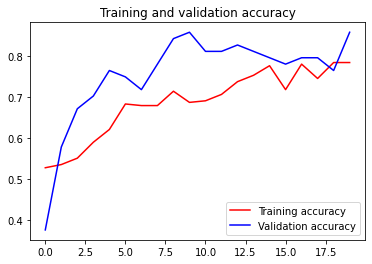

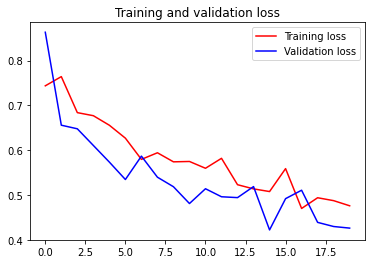

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# View weights learnt by the model
model.save_weights('./checkpoints/my_checkpoint1')
model.save('Capstone/saved_model/my_vgg16')

INFO:tensorflow:Assets written to: Capstone/saved_model/my_vgg16\assets


  0%|          | 0/1000 [00:00<?, ?it/s]

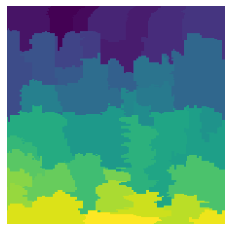

In [ ]:
import lime.lime_image

explainer = lime.lime_image.LimeImageExplainer()
exp = explainer.explain_instance(np.array(image_batch[0]).astype('double'),
                                model.predict,
                                hide_color = 0,
                                num_samples = 1000)
plt.imshow(exp.segments)
plt.axis('off')
plt.show()

In [ ]:
# Features of spectrogram used to identify data as fake -> 1
generate_prediction_sample(exp, exp.top_labels[1], show_positive = True, hide_background = True)

IndexError: list index out of range

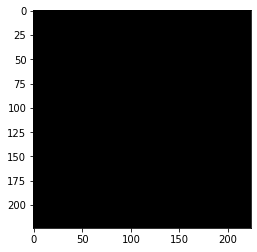

In [ ]:
# Features of spectrogram used to identify data as real -> 0
generate_prediction_sample(exp, exp.top_labels[0], show_positive = True, hide_background = True)

# Inception

In [ ]:
# Load data parameters
batch_size_inception = 16

In [ ]:
train_ds_inception = K.utils.image_dataset_from_directory(str(root),
                                               validation_split = 0.2,
                                               subset = 'training',
                                               seed = 42,
                                               image_size = (img_height, img_width),
                                               batch_size = batch_size_inception)

test_ds_inception = K.utils.image_dataset_from_directory(str(root),
                                               validation_split = 0.2,
                                               subset = 'validation',
                                               seed = 42,
                                               image_size = (img_height, img_width),
                                               batch_size = batch_size_inception)

Found 10208 files belonging to 2 classes.
Using 8167 files for training.
Found 10208 files belonging to 2 classes.
Using 2041 files for validation.


In [ ]:
total_train_samples = len(train_ds)
steps_per_epoch_inception = tf.math.ceil(total_train_samples / batch_size)

In [ ]:
total_val_samples = len(test_ds)
validation_steps_inception = tf.math.ceil(total_val_samples / batch_size)

In [ ]:
base_model = tf.keras.applications.InceptionV3(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights='imagenet')

In [ ]:
NUM_CLASSES = 2

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
dense_layer = tf.keras.layers.Dense(64, activation='relu')
prediction_layer = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')

inception_model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    dense_layer,
    prediction_layer
])

In [ ]:
inception_model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
history_inception = inception_model.fit(
    train_ds,
    epochs=15,
    steps_per_epoch=steps_per_epoch_inception,
    validation_data=test_ds,
    validation_steps=validation_steps_inception,callbacks = tensorboard_callback)

Epoch 1/15
32/32 [==============================] - 37s 769ms/step - loss: 0.5039 - accuracy: 0.8008 - val_loss: 3.5307 - val_accuracy: 0.5469
Epoch 2/15
32/32 [==============================] - 13s 416ms/step - loss: 0.3637 - accuracy: 0.8613 - val_loss: 4.5796 - val_accuracy: 0.4766
Epoch 3/15
32/32 [==============================] - 13s 415ms/step - loss: 0.2540 - accuracy: 0.8926 - val_loss: 3.5487 - val_accuracy: 0.7969
Epoch 4/15
32/32 [==============================] - 14s 437ms/step - loss: 0.2937 - accuracy: 0.8906 - val_loss: 0.7478 - val_accuracy: 0.7656
Epoch 5/15
32/32 [==============================] - 13s 411ms/step - loss: 0.2227 - accuracy: 0.9141 - val_loss: 5.2347 - val_accuracy: 0.3906
Epoch 6/15
32/32 [==============================] - 14s 427ms/step - loss: 0.2028 - accuracy: 0.9199 - val_loss: 4.0942 - val_accuracy: 0.5156
Epoch 7/15
32/32 [==============================] - 13s 415ms/step - loss: 0.2615 - accuracy: 0.9121 - val_loss: 0.1463 - val_accuracy: 0.9375

In [ ]:
inception_model.evaluate(test_ds)

128/128 [==============================] - 15s 115ms/step - loss: 2.2095 - accuracy: 0.5478


[2.2094531059265137, 0.5477706789970398]

# VGG-16

In [ ]:
model_vgg = Sequential()

# Include top - False skips the last FCN layers, that can be customized as per the user
model_vgg.add(VGG16(include_top = False, weights = 'imagenet', input_shape = (img_height, img_width, channels)))
model_vgg.add(Flatten())

model_vgg.add(Dense(512, activation = 'relu'))
model_vgg.add(tf.keras.layers.Dropout(0.3))
model_vgg.add(Dense(512, activation = 'relu'))
model_vgg.add(tf.keras.layers.Dropout(0.3))
model_vgg.add(Dense(1, activation = 'softmax'))
model_vgg.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['acc'])

model_vgg.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               12845568  
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [ ]:
log_dir = "logs/fit/" + "vgg16-" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq = 1)

In [ ]:
# Takes a loooong time, hence 5 epochs only
history = model_vgg.fit(train_ds,
                    validation_data = test_ds,
                    epochs = 2,
                    callbacks = tensorboard_callback)

Epoch 1/2


ResourceExhaustedError:  OOM when allocating tensor with shape[32,256,56,56] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node sequential_1/vgg16/block3_conv2/Relu (defined at <ipython-input-13-a3f587a74b35>:5) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_2644]

Function call stack:
train_function


In [ ]:
# Check predictions
predicted_batch = model_vgg.predict(image_batch)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
print('VGG 16:',predicted_label_batch)

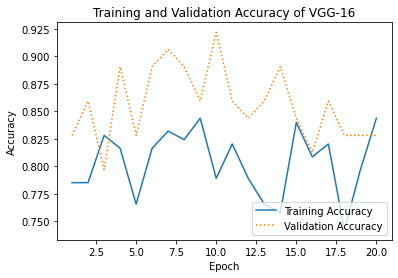

In [ ]:
# Plot accuracy curve
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy of VGG-16')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

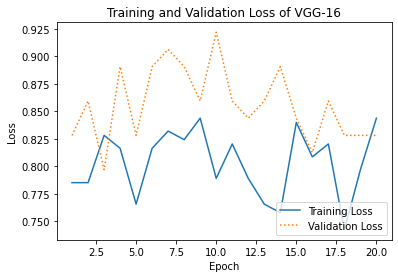

In [ ]:
# Plot loss curve
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Loss')
plt.plot(epochs, val_acc, ':', label='Validation Loss')
plt.title('Training and Validation Loss of VGG-16')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# View weights learnt by the model
model_vgg.save_weights('./checkpoints/my_checkpoint1')
model_vgg.save('Capstone/saved_model/my_vgg16')

## XAI for VGG-16

In [ ]:
import lime.lime_image

explainer = lime.lime_image.LimeImageExplainer()
exp = explainer.explain_instance(np.array(image_batch[0]),
                                model.predict,
                                hide_color = 0,
                                num_samples = 1000)
plt.imshow(exp.segments)
plt.axis('off')
plt.show()

In [ ]:
# Features of spectrogram used to identify data as fake -> 1
generate_prediction_sample(exp, exp.top_labels[1], show_positive = True, hide_background = True)

In [ ]:
# Features of spectrogram used to identify data as real -> 0
generate_prediction_sample(exp, exp.top_labels[0], show_positive = True, hide_background = True)

# MobileNet

In [ ]:
# Download inception v3 model
feature_extractor2 = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"

feature_extractor_layer2 = hub.KerasLayer(
    feature_extractor2,
    input_shape=(224, 224, 3),
    trainable=False)

feature_batch2 = feature_extractor_layer2(image_batch)
print(feature_batch2.shape)

(32, 2048)


In [ ]:
# Load pretrained model. Adding an output layer with 2 neurons
model_mobile = tf.keras.Sequential([
    feature_extractor_layer2,
    tf.keras.layers.Dense(1024, activation = 'relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1024, activation = 'relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model_mobile.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 2048)              21802784  
_________________________________________________________________
dense_12 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dropout_7 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dropout_8 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 1025      
Total params: 24,951,585
Trainable params: 3,148,801
Non-trainable params: 21,802,784
__________________________________

In [ ]:
# Compile the model and define folder to store logs
model_mobile.compile(optimizer=tf.keras.optimizers.Adam(),
                     loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                     metrics=['acc'])

log_dir = "logs/fit/" + "mobile-net-" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq = 1)

In [ ]:
# Takes a while to train. Set to 2 epochs. Increase if needed
history2 = model_mobile.fit(train_ds,
                    validation_data = test_ds,
                    epochs = 2,
                    callbacks = tensorboard_callback)

Epoch 1/2
256/256 [==============================] - 101s 353ms/step - loss: 1.9270 - acc: 0.6679 - val_loss: 0.4873 - val_acc: 0.7457
Epoch 2/2
256/256 [==============================] - 61s 236ms/step - loss: 0.5703 - acc: 0.6978 - val_loss: 0.4768 - val_acc: 0.7594


In [ ]:
# Check predictions
predicted_batch = model_mobile.predict(image_batch)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
print('Mobile net:',predicted_label_batch)

Mobile net: ['fake' 'fake' 'fake' 'fake' 'fake' 'fake' 'fake' 'fake' 'fake' 'fake'
 'fake' 'fake' 'fake' 'fake' 'fake' 'fake' 'fake' 'fake' 'fake' 'fake'
 'fake' 'fake' 'fake' 'fake' 'fake' 'fake' 'fake' 'fake' 'fake' 'fake'
 'fake' 'fake']


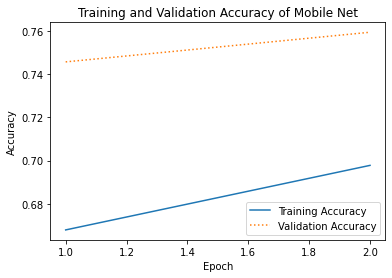

In [ ]:
# Plot accuracy curve
acc = history2.history['acc']
val_acc = history2.history['val_acc']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy of Mobile Net')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

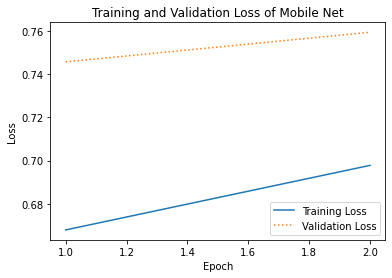

In [ ]:
# Plot loss curve
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Loss')
plt.plot(epochs, val_acc, ':', label='Validation Loss')
plt.title('Training and Validation Loss of Mobile Net')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# View weights learnt by the model
model_mobile.save_weights('./checkpoints/my_checkpoint1')
model_mobile.save('Capstone/saved_model/my_mobilenet_v2')

## XAI for MobileNet

In [ ]:
import lime.lime_image

explainer = lime.lime_image.LimeImageExplainer()
exp = explainer.explain_instance(np.array(image_batch[0]),
                                model_mobile.predict,
                                hide_color = 0,
                                num_samples = 1000)
plt.imshow(exp.segments)
plt.axis('off')
plt.show()

In [ ]:
# Features of spectrogram used to identify data as real -> 0
generate_prediction_sample(exp, exp.top_labels[0], show_positive = True, hide_background = True)

# ResNet

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
import keras

resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(img_height, img_width, channels))

# Do not train the model, leverage pretrained layers
for layer in resnet.layers:
    layer.trainable = False

resnet.summary()

In [ ]:
# Create transfer learning model

model_resnet = Sequential()

# Add pretrained model as it is
model_resnet.add(resnet)
# Flatten last layer of resnet
model_resnet.add(Flatten())
# Add layers of our own
model_resnet.add(Dense(512, activation='relu', input_dim=(img_height, img_width, channels)))
model_resnet.add(tf.keras.layers.Dropout(0.3))
model_resnet.add(Dense(512, activation='relu'))
model_resnet.add(tf.keras.layers.Dropout(0.3))
model_resnet.add(Dense(1, activation='sigmoid'))

model_resnet.summary()

In [ ]:
model_resnet.compile(loss='binary_crossentropy',
                     optimizer=keras.optimizers.RMSprop(learning_rate = 2e-5),
                     metrics=['accuracy'])

log_dir = "logs/fit/" + "resnet-" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq = 1)

In [ ]:
history3 = model_resnet.fit(train_ds,
                    validation_data = test_ds,
                    epochs = 20,
                    callbacks = tensorboard_callback)

In [ ]:
# Check predictions
predicted_batch = model_mobile.predict(image_batch)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
print('ResNet50:',predicted_label_batch)

In [ ]:
# Plot accuracy curve
acc = history3.history['acc']
val_acc = history3.history['val_acc']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy of ResNet50')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Plot loss curve
loss = history3.history['loss']
val_loss = history3.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Loss')
plt.plot(epochs, val_acc, ':', label='Validation Loss')
plt.title('Training and Validation Loss of ResNet50')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# View weights learnt by the model
model_mobile.save_weights('./checkpoints/my_checkpoint1')
model_mobile.save('Capstone/saved_model/my_resnet')

## XAI for ResNet50

In [ ]:
import lime.lime_image

explainer = lime.lime_image.LimeImageExplainer()
exp = explainer.explain_instance(np.array(image_batch[0]),
                                model_mobile.predict,
                                hide_color = 0,
                                num_samples = 1000)
plt.imshow(exp.segments)
plt.axis('off')
plt.show()

In [ ]:
# Features of spectrogram used to identify data as real -> 0
generate_prediction_sample(exp, exp.top_labels[0], show_positive = True, hide_background = True)

# Custom CNN

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense

model_cnn = Sequential()
model_cnn.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model_cnn.add(MaxPooling2D(2, 2))

model_cnn.add(Conv2D(128, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D(2, 2))

model_cnn.add(Conv2D(128, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D(2, 2))

model_cnn.add(Flatten())

model_cnn.add(Dense(512, activation='relu'))
model_cnn.add(tf.keras.layers.Dropout(0.3))

model_cnn.add(Dense(512, activation = 'relu'))
model_cnn.add(tf.keras.layers.Dropout(0.3))

model_cnn.add(Dense(1, activation='softmax'))

model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

log_dir = "logs/fit/" + "resnet-" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq = 1)

model_cnn.summary()

In [ ]:
history4 = model_cnn.fit(train_ds,
                    validation_data = test_ds,
                    epochs = 5,
                    callbacks = tensorboard_callback)

In [ ]:
# Check predictions
predicted_batch = model_mobile.predict(image_batch)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
print('Custom CNN', predicted_label_batch)

In [ ]:
# Plot accuracy curve
acc = history4.history['accuracy']
val_acc = history4.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy of Custom CNN')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Plot loss curve
loss = history4.history['loss']
val_loss = history4.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Loss')
plt.plot(epochs, val_acc, ':', label='Validation Loss')
plt.title('Training and Validation Loss of Custom CNN')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# View weights learnt by the model
model_cnn.save_weights('./checkpoints/my_checkpoint1')
model_cnn.save('Capstone/saved_model/my_cnn')

## XAI for Custom CNN

In [ ]:
import lime.lime_image

explainer = lime.lime_image.LimeImageExplainer()
exp = explainer.explain_instance(np.array(image_batch[0]),
                                model_cnn.predict,
                                hide_color = 0,
                                num_samples = 1000)
plt.imshow(exp.segments)
plt.axis('off')
plt.show()

In [ ]:
# Features of spectrogram used to identify data as real -> 0
generate_prediction_sample(exp, exp.top_labels[0], show_positive = True, hide_background = True)

# HuggingFace Model

In [ ]:
!pip install transformers

  ERROR: Command errored out with exit status 1:
   command: 'E:\Python\envs\gpuenv\python.exe' 'E:\Python\envs\gpuenv\lib\site-packages\pip\_vendor\pep517\in_process\_in_process.py' build_wheel 'C:\Users\hp\AppData\Local\Temp\tmp1jf8735g'
       cwd: C:\Users\hp\AppData\Local\Temp\pip-install-3y8p17_l\tokenizers_606831697a114a83bdc9745cc667188a
  Complete output (51 lines):
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib.win-amd64-3.6
  creating build\lib.win-amd64-3.6\tokenizers
  copying py_src\tokenizers\__init__.py -> build\lib.win-amd64-3.6\tokenizers
  creating build\lib.win-amd64-3.6\tokenizers\models
  copying py_src\tokenizers\models\__init__.py -> build\lib.win-amd64-3.6\tokenizers\models
  creating build\lib.win-amd64-3.6\tokenizers\decoders
  copying py_src\tokenizers\decoders\__init__.py -> build\lib.win-amd64-3.6\tokenizers\decoders
  creating build\lib.win-amd64-3.6\tokenizers\normalizers
  copying py_src\tokenizers\normali


  Using cached transformers-4.18.0-py3-none-any.whl (4.0 MB)
  Using cached PyYAML-6.0-cp36-cp36m-win_amd64.whl (153 kB)
  Using cached regex-2022.10.31-cp36-cp36m-win_amd64.whl (279 kB)
  Using cached tokenizers-0.12.1.tar.gz (220 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Using cached sacremoses-0.0.53-py3-none-any.whl
  Using cached huggingface_hub-0.4.0-py3-none-any.whl (67 kB)
  Using cached filelock-3.4.1-py3-none-any.whl (9.9 kB)
  Using cached click-8.0.4-py3-none-any.whl (97 kB)
Failed to build tokenizers


In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("nielsr/audio-spectogram-transformer-finetuned-audioset-10-10-0.4593")

ModuleNotFoundError: No module named 'transformers'